# Case Study: InvertiaDB
## Temperature & IR Hairpin Distribution

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from collections import defaultdict
from tqdm import tqdm

In [68]:
import os
from pathlib import Path
import numpy as np
from dotenv import load_dotenv

load_dotenv(".env")
IRP_DB = os.getenv("IRP_DB")
EMPTY_DB = os.getenv("EMPTY_DB")
TREE_OF_LIFE = os.getenv("TREE_OF_LIFE")
ASSEMBLY_DB = os.getenv("ASSEMBLY_DB")
TEMPURA_DB = os.getenv("TEMPURA_DB")

# assert os.path.isdir(DATABASE), "Invalid directory!"
assert os.path.isfile(IRP_DB), "Invalid inverted repeats database."
assert os.path.isfile(EMPTY_DB), "Invalid empty assemblies db."
assert os.path.isfile(ASSEMBLY_DB), "Invalid assembly summary path."
assert os.path.isfile(TREE_OF_LIFE), "Invalid tree of life path."
assert os.path.isfile(TEMPURA_DB), "Invalid TEMPURA db."

In [69]:
irp_df = pl.read_parquet(IRP_DB)
print(irp_df.shape)
irp_df

(34330450, 20)


seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,#assembly_accession,superkingdom,kingdom_n,phylum,genome_size,gc_percent
str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,i64,f64
"""chr1_hap1_hsa1""",30582,30608,"""aaaatctgagag""","""ct""","""aaaatctgagagctctctcagatttt""",12,2,26,6,3,1,2,"""6A/1C/3G/2T""","""PongoAbelii""","""Eukaryota""","""Animalia""","""Chordata""",3259853530,NaN
"""chr1_hap1_hsa1""",37880,37907,"""tagcattagg""","""agatata""","""tagcattaggagatatacctaatgcta""",10,7,27,3,3,1,3,"""3A/1C/3G/3T""","""PongoAbelii""","""Eukaryota""","""Animalia""","""Chordata""",3259853530,NaN
"""chr1_hap1_hsa1""",47524,47549,"""tcagatcctca""","""ata""","""tcagatcctcaatatgaggatctga""",11,3,25,3,1,4,3,"""3A/4C/1G/3T""","""PongoAbelii""","""Eukaryota""","""Animalia""","""Chordata""",3259853530,NaN
"""chr1_hap1_hsa1""",58762,58790,"""tcagggagat""","""cagagaat""","""tcagggagatcagagaatatctccctga""",10,8,28,3,4,1,2,"""3A/1C/4G/2T""","""PongoAbelii""","""Eukaryota""","""Animalia""","""Chordata""",3259853530,NaN
"""chr1_hap1_hsa1""",80119,80147,"""tttttgccatt""","""gaatgt""","""tttttgccattgaatgtaatggcaaaaa""",11,6,28,1,1,2,7,"""1A/2C/1G/7T""","""PongoAbelii""","""Eukaryota""","""Animalia""","""Chordata""",3259853530,NaN
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""NZ_LR135336.1""",2039,2067,"""taaaaataac""","""tttattgt""","""taaaaataactttattgtgttattttta""",10,8,28,7,0,1,2,"""7A/1C/0G/2T""","""GCF_900639495.1""","""Bacteria""","""Eubacteria""","""Bacillota""",3273252,0.375
"""NZ_LR135336.1""",8735,8769,"""aaagccccagaga""","""ggtcggat""","""aaagccccagagaggtcggattctctgggg…",13,8,34,6,3,4,0,"""6A/4C/3G/0T""","""GCF_900639495.1""","""Bacteria""","""Eubacteria""","""Bacillota""",3273252,0.375
"""NZ_LR135337.1""",4311,4336,"""tgttactctttg""","""t""","""tgttactctttgtcaaagagtaaca""",12,1,25,1,2,2,7,"""1A/2C/2G/7T""","""GCF_900639495.1""","""Bacteria""","""Eubacteria""","""Bacillota""",3273252,0.375


In [70]:
irp_df["spacerLength"].max(), irp_df["armLength"].min()

(8, 10)

In [71]:
df_empty = pl.read_csv(EMPTY_DB,
                separator="\t",
                schema_overrides={
                                 "total_gene_count": pl.Utf8,
                                 "protein_coding_gene_count": pl.Utf8,
                                 "non_coding_gene_count": pl.Utf8
                                }
                )
df_empty

#assembly_accession,IR,accession_id,organism_name,group,genome_size,genus,gc_percent,total_gene_count,protein_coding_gene_count,non_coding_gene_count,family,order,class,phylum,kingdom,superkingdom
str,i64,str,str,str,i64,str,f64,str,str,str,str,str,str,str,str,str
"""GCF_000002515.2""",0,"""GCF_000002515.2""","""Kluyveromyces lactis""","""fungi""",10689156,"""Kluyveromyces""",0.39,"""5335""","""5084""","""251""","""Saccharomycetaceae""","""Saccharomycetales""","""Saccharomycetes""","""Ascomycota""","""Fungi""","""Eukaryota"""
"""GCF_000002725.2""",0,"""GCF_000002725.2""","""Leishmania major strain Friedl…","""protozoa""",32855089,"""Leishmania""",0.595,"""9388""","""8316""","""976""","""Trypanosomatidae""","""Trypanosomatida""","""Kinetoplastea""","""Euglenozoa""","""Protista""","""Eukaryota"""
"""GCF_000002765.6""",0,"""GCF_000002765.6""","""Plasmodium falciparum 3D7""","""protozoa""",23292622,"""Plasmodium""",0.195,"""5615""","""5282""","""175""","""Plasmodiidae""","""Haemosporida""","""Aconoidasida""","""Apicomplexa""","""Protista""","""Eukaryota"""
"""GCF_000002985.6""",0,"""GCF_000002985.6""","""Caenorhabditis elegans""","""invertebrate""",100272607,"""Caenorhabditis""",0.355,"""46927""","""19984""","""24811""","""Rhabditidae""","""Rhabditida""","""Chromadorea""","""Nematoda""","""Metazoa""","""Eukaryota"""
"""GCF_000005825.2""",0,"""GCF_000005825.2""","""Alkalihalophilus pseudofirmus …","""bacteria""",4249248,"""Alkalihalophilus""",0.4,"""4314""","""4158""","""105""","""Bacillaceae""","""Bacillales""","""Bacilli""","""Bacillota""","""Bacillati""","""Bacteria"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""GCF_000219725.1""",0,"""GCF_000219725.1""","""Gracilinema caldarium DSM 7334""","""bacteria""",3239340,"""Gracilinema""",0.455,"""2934""","""2851""","""60""","""Breznakiellaceae""","""Spirochaetales""","""Spirochaetia""","""Spirochaetota""","""Pseudomonadati""","""Bacteria"""
"""GCF_000847005.1""",0,"""GCF_000847005.1""","""Gallid alphaherpesvirus 1""","""viral""",148687,"""Iltovirus""",0.48,"""79""","""79""","""0""","""Orthoherpesviridae""","""Herpesvirales""","""Herviviricetes""","""Peploviricota""","""Heunggongvirae""","""Viruses"""
"""GCF_000847605.1""",0,"""GCF_000847605.1""","""Equine infectious anemia virus""","""viral""",8359,"""Lentivirus""",0.385,"""4""","""4""","""0""","""Retroviridae""","""Ortervirales""","""Revtraviricetes""","""Artverviricota""","""Pararnavirae""","""Viruses"""


In [72]:
empty_accessions = df_empty.filter(pl.col("IR") == 1)['group'].value_counts()
empty_accessions

group,count
str,u32
"""bacteria""",1
"""viral""",32874


In [73]:
empty_accessions = set(df_empty.filter(pl.col("IR") == 1)['#assembly_accession'])
len(empty_accessions)

32861

In [74]:
non_empty_accessions = set(irp_df["#assembly_accession"])
len(non_empty_accessions)

85240

In [75]:
DB_accessions = empty_accessions | non_empty_accessions
total_DB_accessions = len(DB_accessions)
total_DB_accessions

118101

In [76]:
dest = Path("tempura_IR_analysis")
dest.mkdir(exist_ok=True)

In [77]:
tree_of_life = pl.read_csv(TREE_OF_LIFE, separator=",")

summary = pl.read_csv(ASSEMBLY_DB, 
                        null_values=['na', 'NA'],
                        has_header=False, 
                    separator="\t")\
                        .rename({"column_1": "#assembly_accession",
                               "column_27": "genome_size",
                               "column_28": "gc_percent",
                                "column_25": "group",
                               "column_6": "taxid",
                               "column_7": "species_taxid",
                        })
summary.head()

#assembly_accession,column_2,column_3,column_4,column_5,taxid,species_taxid,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,group,column_26,genome_size,gc_percent,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38
str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,f64,i64,i64,i64,str,str,str,i64,i64,i64,str
"""GCF_000762265.1""","""PRJNA224116""","""SAMN03085433""",null,null,2162,2162,"""Methanobacterium formicicum""","""strain=BRM9""",null,"""latest""","""Complete Genome""","""Major""","""Full""","""2014/10/02""","""ASM76226v1""","""PGgRc""","""GCA_000762265.1""","""identical""","""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""archaea""",2449987,2449987,41.5,1,1,1,"""NCBI RefSeq""","""NCBI Prokaryotic Genome Annota…","""2024/02/11""",2445,2386,55,null
"""GCF_001458655.1""","""PRJNA224116""","""SAMEA2779801""",null,"""representative genome""",2162,2162,"""Methanobacterium formicicum""",null,"""Mb9""","""latest""","""Complete Genome""","""Major""","""Full""","""2015/11/16""","""Mb9""","""CEBITEC""","""GCA_001458655.1""","""identical""","""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""archaea""",2494510,2494510,41.0,1,1,1,"""NCBI RefSeq""","""NCBI Prokaryotic Genome Annota…","""2024/02/12""",2462,2404,55,null
"""GCF_002813085.1""","""PRJNA224116""","""SAMN05935551""",null,null,2173,2173,"""Methanobrevibacter smithii""","""strain=KB11""",null,"""latest""","""Complete Genome""","""Major""","""Full""","""2017/12/06""","""ASM281308v1""","""KRIBB""","""GCA_002813085.1""","""identical""","""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""archaea""",1805545,1805545,31.0,1,1,1,"""NCBI RefSeq""","""NCBI Prokaryotic Genome Annota…","""2024/02/19""",1782,1715,43,null
"""GCF_022846155.1""","""PRJNA224116""","""SAMD00389909""",null,null,2173,2173,"""Methanobrevibacter smithii""","""strain=CE91-St67""",null,"""latest""","""Complete Genome""","""Major""","""Full""","""2022/02/04""","""ASM2284615v1""","""Laboratory for Microbiome Scie…","""GCA_022846155.1""","""identical""","""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""archaea""",1791153,1791153,31.0,1,1,1,"""NCBI RefSeq""","""NCBI Prokaryotic Genome Annota…","""2023/04/21""",1738,1680,44,null
"""GCF_022846175.1""","""PRJNA224116""","""SAMD00389910""",null,null,2173,2173,"""Methanobrevibacter smithii""","""strain=CE91-St68""",null,"""latest""","""Complete Genome""","""Major""","""Full""","""2022/02/04""","""ASM2284617v1""","""Laboratory for Microbiome Scie…","""GCA_022846175.1""","""identical""","""https://ftp.ncbi.nlm.nih.gov/g…",null,null,null,"""haploid""","""archaea""",1791155,1791155,31.0,1,1,1,"""NCBI RefSeq""","""NCBI Prokaryotic Genome Annota…","""2023/04/21""",1739,1681,44,null


# Load Tempura DB

In [78]:
tempura_DB = pl.read_csv(TEMPURA_DB)
tempura_DB

genus_and_species,taxonomy_id,strain,superkingdom,phylum,class,order,family,genus,assembly_or_accession,Genome_GC,Genome_size,16S_accssion,16S_GC,Tmin,Topt_ave,Topt_low,Topt_high,Tmax,Tmax_Tmin
str,i64,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
"""Methanopyrus kandleri""",2320,"""116""","""Archaea""","""Euryarchaeota""","""Methanopyri""","""Methanopyrales""","""Methanopyraceae""","""Methanopyrus""",null,null,null,"""AB301476""",67.7,85.0,100.0,null,null,122.0,37.0
"""""Geogemma barossii""""",1927912,"""121""","""Archaea""","""Crenarchaeota""","""Thermoprotei""","""Desulfurococcales""","""Pyrodictiaceae""","""Geogemma""",null,null,null,null,null,85.0,106.0,null,null,121.0,36.0
"""Pyrolobus fumarii""",54252,"""1A""","""Archaea""","""Crenarchaeota""","""Thermoprotei""","""Desulfurococcales""","""Pyrodictiaceae""","""Pyrolobus""","""GCA_000223395.1""",54.9,1.8,"""X99555""",68.4,90.0,106.0,null,null,113.0,23.0
"""Pyrococcus kukulkanii""",1609559,"""NCB100""","""Archaea""","""Euryarchaeota""","""Thermococci""","""Thermococcales""","""Thermococcaceae""","""Pyrococcus""","""GCA_001577775.1""",44.6,2.0,"""CP010835""",66.5,70.0,105.0,null,null,112.0,42.0
"""Methanopyrus kandleri""",2320,"""AV19""","""Archaea""","""Euryarchaeota""","""Methanopyri""","""Methanopyrales""","""Methanopyraceae""","""Methanopyrus""","""GCA_000007185.1""",61.2,1.7,"""NR_074539""",68.1,84.0,98.0,null,null,110.0,38.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Moritella profunda""",111291,"""2674""","""Bacteria""","""Proteobacteria""","""Gammaproteobacteria""","""Alteromonadales""","""Moritellaceae""","""Moritella""",null,41.4,null,"""AJ252023""",52.9,2.0,2.0,null,null,12.0,10.0
"""Lacinutrix jangbogonensis""",1469557,"""PAMC 27137""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Lacinutrix""",null,32.1,null,"""KF977035""",49.5,4.0,10.0,null,null,10.0,6.0
"""Desulfofaba gelida""",84981,"""PSv29""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Desulfobacterales""","""Desulfobacteraceae""","""Desulfofaba""",null,52.8,null,"""AF099063""",52.9,-2.0,7.0,null,null,10.0,11.8


In [79]:
tempura_DB["assembly_or_accession"].is_null().sum()

7577

In [80]:
def classify(temp):
    if temp < 20:
        return "Psychrophiles"
    if temp < 45:
        return "Mesophiles"
    if temp < 80:
        return "Thermophiles"
    return "Hyperthermophiles"
    
    
tempura_DB_merged = tempura_DB.join(
                            summary.select(["#assembly_accession", "group", "taxid", "species_taxid", "genome_size", "gc_percent"]), 
                                    left_on="taxonomy_id", 
                                    right_on="species_taxid", 
                                    how="inner"
                                )\
                        .with_columns(
                                    pl.col("Topt_ave").map_elements(classify, return_dtype=str)
                                   .alias("thermo_class")
                        )\
                    .filter(pl.col("superkingdom") == "Bacteria")
print(tempura_DB_merged["thermo_class"].value_counts())
print(tempura_DB_merged["group"].unique())
tempura_DB_merged

shape: (4, 2)
┌───────────────────┬───────┐
│ thermo_class      ┆ count │
│ ---               ┆ ---   │
│ str               ┆ u32   │
╞═══════════════════╪═══════╡
│ Hyperthermophiles ┆ 30    │
│ Mesophiles        ┆ 6753  │
│ Thermophiles      ┆ 504   │
│ Psychrophiles     ┆ 107   │
└───────────────────┴───────┘
shape: (1,)
Series: 'group' [str]
[
	"bacteria"
]


genus_and_species,taxonomy_id,strain,superkingdom,phylum,class,order,family,genus,assembly_or_accession,Genome_GC,Genome_size,16S_accssion,16S_GC,Tmin,Topt_ave,Topt_low,Topt_high,Tmax,Tmax_Tmin,#assembly_accession,group,taxid,genome_size,gc_percent,thermo_class
str,i64,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,str,str,i64,i64,f64,str
"""Myxococcus xanthus""",34,"""FB""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Myxococcales""","""Myxococcaceae""","""Myxococcus""","""GCA_000012685.1""",68.9,9.1,"""AB218205""",56.0,25.0,29.0,26.0,32.0,35.0,10.0,"""GCF_006402735.1""","""bacteria""",34,9316447,69.0,"""Mesophiles"""
"""Myxococcus xanthus""",34,"""FB""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Myxococcales""","""Myxococcaceae""","""Myxococcus""","""GCA_000012685.1""",68.9,9.1,"""AB218205""",56.0,25.0,29.0,26.0,32.0,35.0,10.0,"""GCF_006401215.1""","""bacteria""",34,9262965,69.0,"""Mesophiles"""
"""Myxococcus xanthus""",34,"""FB""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Myxococcales""","""Myxococcaceae""","""Myxococcus""","""GCA_000012685.1""",68.9,9.1,"""AB218205""",56.0,25.0,29.0,26.0,32.0,35.0,10.0,"""GCF_006400955.1""","""bacteria""",34,9321034,69.0,"""Mesophiles"""
"""Myxococcus xanthus""",34,"""FB""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Myxococcales""","""Myxococcaceae""","""Myxococcus""","""GCA_000012685.1""",68.9,9.1,"""AB218205""",56.0,25.0,29.0,26.0,32.0,35.0,10.0,"""GCF_006401635.1""","""bacteria""",34,8952969,69.0,"""Mesophiles"""
"""Myxococcus xanthus""",34,"""FB""","""Bacteria""","""Proteobacteria""","""Deltaproteobacteria""","""Myxococcales""","""Myxococcaceae""","""Myxococcus""","""GCA_000012685.1""",68.9,9.1,"""AB218205""",56.0,25.0,29.0,26.0,32.0,35.0,10.0,"""GCF_006402415.1""","""bacteria""",34,9316378,69.0,"""Mesophiles"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Capnocytophaga endodontalis""",2708117,"""ChDC OS43""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Capnocytophaga""","""GCA_002209445.1""",38.2,3.4,"""NR_165677""",50.9,30.0,35.0,null,null,40.0,10.0,"""GCA_002209445.1""","""bacteria""",2708117,3412686,38.0,"""Mesophiles"""
"""Salaquimonas pukyongi""",2712698,"""RR3-28""","""Bacteria""","""Proteobacteria""","""Alphaproteobacteria""","""Rhizobiales""","""Phyllobacteriaceae""","""Salaquimonas""","""GCA_001953055.1""",58.6,3.4,"""MG889584""",55.1,20.0,27.5,25.0,30.0,35.0,15.0,"""GCA_001953055.1""","""bacteria""",2712698,3357577,58.5,"""Mesophiles"""
"""Acaryochloris marina""",155978,"""MBIC11017""","""Bacteria""","""Cyanobacteria""",null,"""Synechococcales""","""Acaryochloridaceae""","""Acaryochloris""","""GCA_000018105.1""",47.0,8.4,"""AB058298""",54.7,20.0,29.0,28.0,30.0,35.0,15.0,"""GCA_018336915.1""","""bacteria""",2762553,7112772,47.0,"""Mesophiles"""


In [81]:
accessions = list(set(tempura_DB_merged['#assembly_accession']))

In [82]:
total_DB_accessions

118101

In [83]:
mutual_DB_accessions_with_TEMPURA = DB_accessions.intersection(accessions)
len(mutual_DB_accessions_with_TEMPURA)

3894

### Merge IR-DB with TEMPURA Database & Keep Only Bacteria

In [84]:
irp_df.shape

(34330450, 20)

In [85]:
irp_df_tempura = irp_df\
                    .with_columns(
                                pl.col("gc_percent") * 1e2 
                    ).join(
                             tempura_DB_merged, 
                             left_on="#assembly_accession",
                             right_on="#assembly_accession", 
                             how="inner",
                            suffix="_tempura")
irp_df_tempura

seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,#assembly_accession,superkingdom,kingdom_n,phylum,genome_size,gc_percent,genus_and_species,taxonomy_id,strain,superkingdom_tempura,phylum_tempura,class,order,family,genus,assembly_or_accession,Genome_GC,Genome_size,16S_accssion,16S_GC,Tmin,Topt_ave,Topt_low,Topt_high,Tmax,Tmax_Tmin,group,taxid,genome_size_tempura,gc_percent_tempura,thermo_class
str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,i64,f64,str,i64,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,f64,str
"""AE017194.1""",1785,1813,"""acagtctatc""","""cacatgta""","""acagtctatccacatgtagatagactgt""",10,8,28,3,1,3,3,"""3A/3C/1G/3T""","""GCA_000008005.1""","""Bacteria""","""Eubacteria""","""Bacillota""",5432652,35.5,"""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,"""bacteria""",222523,5432652,35.5,"""Mesophiles"""
"""AE017194.1""",9064,9088,"""aagaggggagat""",""".""","""aagaggggagatatctcccctctt""",12,0,24,5,6,0,1,"""5A/0C/6G/1T""","""GCA_000008005.1""","""Bacteria""","""Eubacteria""","""Bacillota""",5432652,35.5,"""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,"""bacteria""",222523,5432652,35.5,"""Mesophiles"""
"""AE017194.1""",10867,10890,"""attgatgaac""","""gct""","""attgatgaacgctgttcatcaat""",10,3,23,4,2,1,3,"""4A/1C/2G/3T""","""GCA_000008005.1""","""Bacteria""","""Eubacteria""","""Bacillota""",5432652,35.5,"""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,"""bacteria""",222523,5432652,35.5,"""Mesophiles"""
"""AE017194.1""",14322,14352,"""aaaaacacaagtc""","""tttt""","""aaaaacacaagtcttttgacttgtgttttt""",13,4,30,8,1,3,1,"""8A/3C/1G/1T""","""GCA_000008005.1""","""Bacteria""","""Eubacteria""","""Bacillota""",5432652,35.5,"""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,"""bacteria""",222523,5432652,35.5,"""Mesophiles"""
"""AE017194.1""",20272,20304,"""aactcccgtccct""","""ttatat""","""aactcccgtccctttatatagggacgggag…",13,6,32,2,1,7,3,"""2A/7C/1G/3T""","""GCA_000008005.1""","""Bacteria""","""Eubacteria""","""Bacillota""",5432652,35.5,"""Bacillus cereus""",1396,"""ATCC 14579""","""Bacteria""","""Firmicutes""","""Bacilli""","""Bacillales""","""Bacillaceae""","""Bacillus""","""GCA_006094295.1""",35.3,5.4,"""D16266""",53.4,10.0,37.0,null,null,45.0,35.0,"""bacteria""",222523,5432652,35.5,"""Mesophiles"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""NZ_OY843610.1""",4405625,4405653,"""aaaaatgcccac""","""tatt""","""aaaaatgcccactattgtgggcattttt""",12,4,28,6,1,4,1,"""6A/4C/1G/1T""","""GCF_963692985.1""","""Bacteria""","""Eubacteria""","""Bacteroidota""",4490751,36.0,"""Maribacter dokdonensis""",320912,"""DSW-8""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavobacteriaceae""","""Maribacter""",null,36.1,null,"""AY960749""",54.2,4.0,30.0,null,null,35.0,31.0,"""bacteria""",320912,4490751,36.0,"""Mesophiles"""
"""NZ_OY843610.1""",4454730,4454752,"""acctgcctgcc""",""".""","""acctgcctgccggcaggcaggt""",11,0,22,1,2,6,2,"""1A/6C/2G/2T""","""GCF_963692985.1""","""Bacteria""","""Eubacteria""","""Bacteroidota""",4490751,36.0,"""Maribacter dokdonensis""",320912,"""DSW-8""","""Bacteria""","""Bacteroidetes""","""Flavobacteriia""","""Flavobacteriales""","""Flavoba

In [86]:
for col in ["superkingdom", "genome_size"]:
    print(col)
    print(irp_df_tempura.filter(pl.col(col) != pl.col(f"{col}_tempura")).select([col, f"{col}_tempura"]))

superkingdom
shape: (0, 2)
┌──────────────┬──────────────────────┐
│ superkingdom ┆ superkingdom_tempura │
│ ---          ┆ ---                  │
│ str          ┆ str                  │
╞══════════════╪══════════════════════╡
└──────────────┴──────────────────────┘
genome_size
shape: (0, 2)
┌─────────────┬─────────────────────┐
│ genome_size ┆ genome_size_tempura │
│ ---         ┆ ---                 │
│ i64         ┆ i64                 │
╞═════════════╪═════════════════════╡
└─────────────┴─────────────────────┘


In [87]:
TEMPURA_accessions_without_IR = mutual_DB_accessions_with_TEMPURA - set(irp_df_tempura["#assembly_accession"])
TEMPURA_accessions_without_IR

{'GCA_036812565.1'}

In [88]:
tempura_DB_merged['thermo_class'].value_counts()

thermo_class,count
str,u32
"""Thermophiles""",504
"""Psychrophiles""",107
"""Mesophiles""",6753
"""Hyperthermophiles""",30


## IR Frequency (%) Spacer Length Distribution

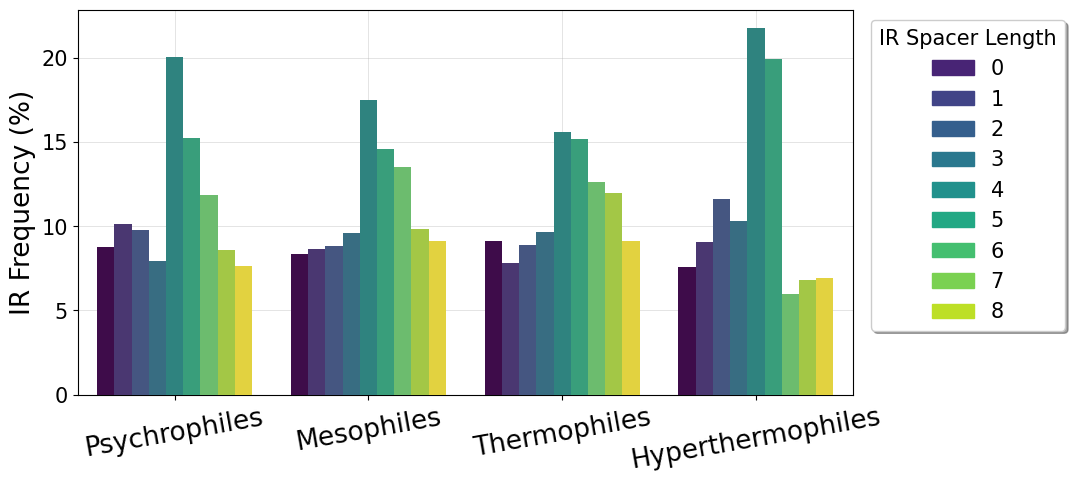

In [89]:
total_IR_per_class = irp_df_tempura.group_by("thermo_class", maintain_order=True)\
                            .agg(
                                pl.col("start").count().alias("IR_counts_global")
                            )


total_IR = irp_df_tempura.group_by(["thermo_class", "spacerLength"], maintain_order=True)\
                .agg(
                pl.col("start").count().alias("IR_counts"))\
                .join(
                        total_IR_per_class,
                        how="left",
                        on="thermo_class",
                )\
                .with_columns(
                                (pl.col("IR_counts") * 1e2 / pl.col("IR_counts_global")).alias("IR_perc")
)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5)) #, gridspec_kwargs={"wspace": 0.1})
# motifs_in_terminators["divergence"] = 100.0 - motifs_in_terminators["score"]
# compartments = ["Terminator", "Gene", "Promoter"]
thermo_class = ["Psychrophiles", 
                "Mesophiles", 
                "Thermophiles", 
                "Hyperthermophiles"]

sns.barplot(
        data=total_IR,
        x="thermo_class",
        y="IR_perc",
        hue="spacerLength",
        capsize=.2,
        ax=ax,
        palette="viridis",
        order=thermo_class,
        # palette={"terminator": sns.color_palette("Set3")[2],
        #         "promoter": sns.color_palette("Set3")[0],
        #         "gene": sns.color_palette("Set3")[8]
        #        },
        zorder=3
)

colors = [cm.viridis(i) for i in np.arange(0.1, 1.1, 0.1)]
handles = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(9)]

ax.legend(title="IR Spacer Length", 
          title_fontsize=15, 
          handles=handles, 
          prop={"size": 15}, 
          fancybox=True, 
          frameon=True, 
          shadow=True, 
          bbox_to_anchor=(1.01, 1.0))
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", labelsize=15)
ax.tick_params(axis="x", labelsize=19, rotation=10)
ax.set_ylabel("IR Frequency (%)")
ax.yaxis.label.set_size(19)
ax.set_xlabel('')
fig.savefig(f"{dest}/IR_percentage_thermo_class_spacer_length.png", bbox_inches='tight')

## IR Frequency (%) Arm Length Distribution

In [90]:
dest

PosixPath('tempura_IR_analysis')

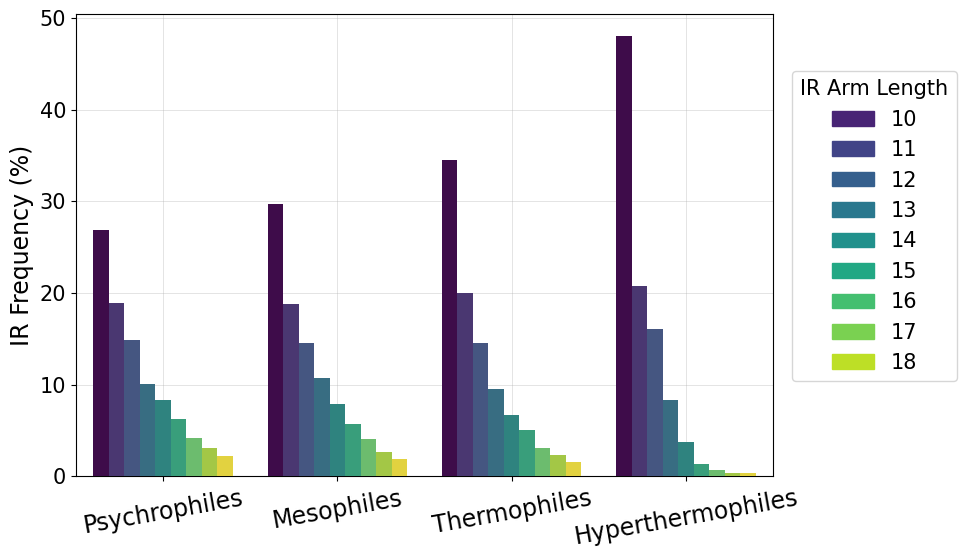

In [91]:

total_IR_per_class = irp_df_tempura.group_by("thermo_class", maintain_order=True).agg(pl.col("start").count().alias("IR_counts_global"))


total_IR = irp_df_tempura.group_by(["thermo_class", "armLength"], maintain_order=True)\
                .agg(pl.col("start").count().alias("IR_counts"))\
                .join(
                        total_IR_per_class,
                        how="left",
                        on="thermo_class",
                )\
                .with_columns(
                                (pl.col("IR_counts") * 1e2 / pl.col("IR_counts_global")).alias("IR_perc")
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
thermo_class = ["Psychrophiles", "Mesophiles", "Thermophiles", "Hyperthermophiles"]


colors = [cm.viridis(i) for i in np.arange(0.1, 1.0, 0.1)]
max_arm = 18
handles = [mpatches.Patch(color=colors[i], label=str(j)) for i, j in enumerate(range(10, max_arm+1))]

sns.barplot(
        data=total_IR.filter(pl.col("armLength") <= max_arm),
        x="thermo_class",
        y="IR_perc",
        hue="armLength",
        capsize=.2,
        ax=ax,
        palette="viridis",
        order=thermo_class,
        # palette={"terminator": sns.color_palette("Set3")[2],
        #         "promoter": sns.color_palette("Set3")[0],
        #         "gene": sns.color_palette("Set3")[8]
        #        },
        zorder=3
)
# ax.axhline(1.0, linestyle='--', lw=1.0, color='black', zorder=5)
ax.legend(title="IR Arm Length", 
          title_fontsize=15, 
          handles=handles, 
          prop={"size": 15}, 
          fancybox=True, 
          frameon=True, 
          bbox_to_anchor=(1.012, 0.9))
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", labelsize=15)
ax.tick_params(axis="x", labelsize=17, rotation=10)
ax.set_ylabel("IR Frequency (%)")
ax.yaxis.label.set_size(17)
ax.set_xlabel('')
fig.savefig(f"{dest}/IR_percentage_thermo_class_increasing_arm_length.png", bbox_inches='tight')

## IR Arm Sequence GC-Enrichment

In [92]:
total_IR_per_class = irp_df_tempura\
            .with_columns(
                    pl.col("gc_percent") / 1e2
            )

total_IR_per_class = total_IR_per_class\
            .with_columns(
                    pl.col("sequenceOfArm").map_elements(lambda seq: seq.count("g") + seq.count("c"),
                                                         return_dtype=int)
                    .alias("gc_arm_content"),
            )\
            .group_by(["#assembly_accession", "spacerLength"], 
                      maintain_order=True)\
                                  .agg(
                                      pl.col("gc_arm_content").sum(),
                                      pl.col("armLength").sum().alias("total_arm_length"),
                                      pl.col("gc_percent").first(),
                                      pl.col("thermo_class").first()
                                    )\
            .with_columns(
                        ((pl.col("gc_arm_content") / pl.col("total_arm_length")).alias("gc_content_ratio")
                        )
            )\
            .with_columns(
                       ( pl.col("gc_content_ratio") / pl.col("gc_percent"))
                    .alias("gc_arm_enrichment")
            )

total_IR_per_class

#assembly_accession,spacerLength,gc_arm_content,total_arm_length,gc_percent,thermo_class,gc_content_ratio,gc_arm_enrichment
str,i64,i64,i64,f64,str,f64,f64
"""GCA_000008005.1""",8,645,1924,0.355,"""Mesophiles""",0.335239,0.944335
"""GCA_000008005.1""",0,400,1357,0.355,"""Mesophiles""",0.294768,0.830332
"""GCA_000008005.1""",3,645,1915,0.355,"""Mesophiles""",0.336815,0.948774
"""GCA_000008005.1""",4,1108,3338,0.355,"""Mesophiles""",0.331935,0.935029
"""GCA_000008005.1""",6,1041,3101,0.355,"""Mesophiles""",0.335698,0.945629
…,…,…,…,…,…,…,…
"""GCF_963692985.1""",0,245,733,0.36,"""Mesophiles""",0.334243,0.928452
"""GCF_963692985.1""",1,171,580,0.36,"""Mesophiles""",0.294828,0.818966
"""GCF_963692985.1""",4,403,1150,0.36,"""Mesophiles""",0.350435,0.97343


/tmp/ipykernel_2705486/1684865589.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [cm.get_cmap("Spectral", lut=None).reversed()(i) for i in np.arange(0.1, 1.1, 0.1)]


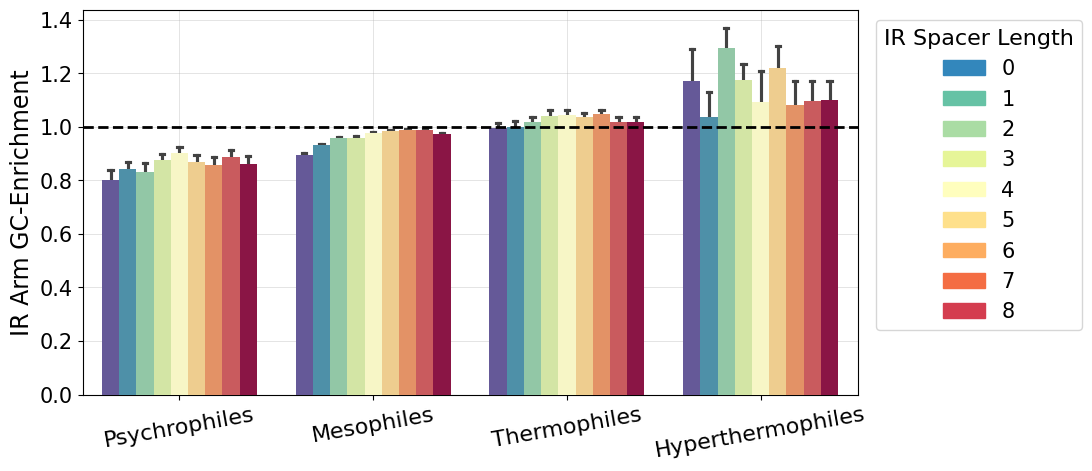

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
thermo_class = ["Psychrophiles", "Mesophiles", "Thermophiles", "Hyperthermophiles"]

sns.barplot(
        data=total_IR_per_class,
        x="thermo_class",
        y="gc_arm_enrichment",
        hue="spacerLength",
        capsize=.2,
        ax=ax,
        hue_order=list(range(9)),
        palette="Spectral_r",
        order=thermo_class,
        # palette={"terminator": sns.color_palette("Set3")[2],
        #         "promoter": sns.color_palette("Set3")[0],
        #         "gene": sns.color_palette("Set3")[8]
        #        },
        zorder=3
)



colors = [cm.get_cmap("Spectral", lut=None).reversed()(i) for i in np.arange(0.1, 1.1, 0.1)]
handles = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(9)]

ax.axhline(1.0, linestyle='--', lw=2.0, color='black', zorder=5)
ax.legend(title="IR Spacer Length", handles=handles, prop={"size": 15}, fancybox=True, frameon=True, 
          title_fontsize=16, bbox_to_anchor=(1.01, 1.0))
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", labelsize=15)
ax.tick_params(axis="x", labelsize=16, rotation=10)
ax.set_ylabel("IR Arm GC-Enrichment")
ax.yaxis.label.set_size(17)
ax.set_xlabel('')
fig.savefig(f"{dest}/IR_GC_enrichment_arm_thermo_class_avg.png", bbox_inches='tight')

## GC Spacer Sequence Enrichment

/tmp/ipykernel_2705486/3958399115.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [cm.get_cmap("Spectral", lut=None).reversed()(i) for i in np.arange(0.1, 1.1, 0.1)]


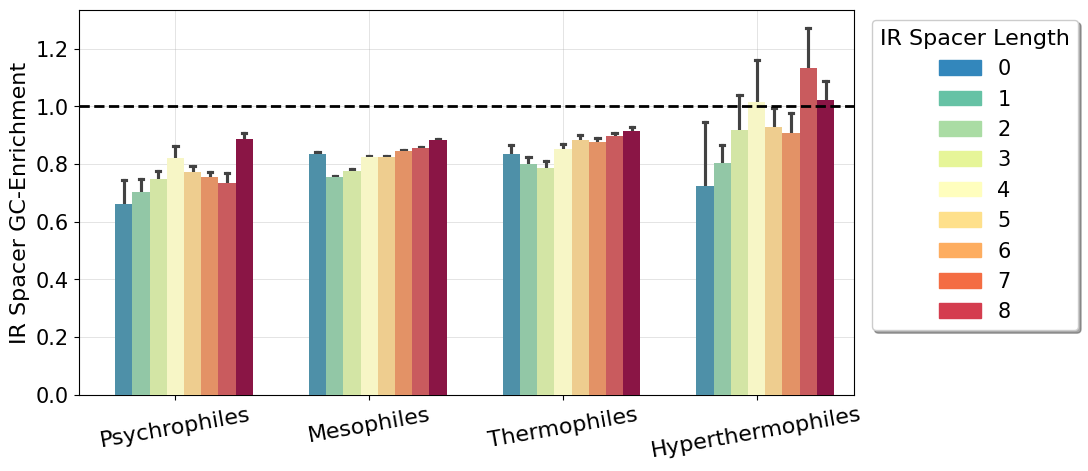

In [94]:
total_IR_per_class = irp_df_tempura\
            .with_columns(
                    pl.col("gc_percent") / 1e2
            )

total_IR_per_class = total_IR_per_class\
            .with_columns(
                    pl.col("sequenceOfSpacer").map_elements(lambda seq: seq.count("g") + seq.count("c"),
                                                         return_dtype=int)
                    .alias("gc_spacer_content"),
            )\
            .group_by(["#assembly_accession", "spacerLength"], 
                      maintain_order=True)\
                                  .agg(
                                      pl.col("gc_spacer_content").sum(),
                                      pl.col("spacerLength").sum().alias("total_spacer_length"),
                                      pl.col("gc_percent").first(),
                                      pl.col("thermo_class").first()
                                    )\
            .with_columns(
                        ((pl.col("gc_spacer_content") / pl.col("total_spacer_length")).alias("gc_content_ratio")
                        )
            )\
            .with_columns(
                       ( pl.col("gc_content_ratio") / pl.col("gc_percent"))
                    .alias("gc_spacer_enrichment")
            )
                        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
thermo_class = ["Psychrophiles", "Mesophiles", "Thermophiles", "Hyperthermophiles"]

sns.barplot(
        data=total_IR_per_class,
        x="thermo_class",
        y="gc_spacer_enrichment",
        hue="spacerLength",
        capsize=.2,
        ax=ax,
        palette="Spectral_r",
        order=thermo_class,
        hue_order=list(range(9)),
        zorder=3
)

colors = [cm.get_cmap("Spectral", lut=None).reversed()(i) for i in np.arange(0.1, 1.1, 0.1)]
handles = [mpatches.Patch(color=colors[i], label=str(i)) for i in range(9)]

ax.axhline(1.0, linestyle='--', lw=2.0, color='black', zorder=5)
ax.legend(title="IR Spacer Length", 
          title_fontsize=16,
          handles=handles, 
          prop={"size": 15}, 
          fancybox=True, 
          frameon=True,
          shadow=True, 
          bbox_to_anchor=(1.01, 1.0))
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", labelsize=15)
ax.tick_params(axis="x", labelsize=16, rotation=10)
ax.set_ylabel("IR Spacer GC-Enrichment")
ax.yaxis.label.set_size(16)
ax.set_xlabel('')
fig.savefig(f"{dest}/IR_GC_enrichment_spacer_thermo_class_avg.png", bbox_inches='tight')

In [95]:
irp_df_tempura.unique(["#assembly_accession"])["thermo_class"].value_counts()

thermo_class,count
str,u32
"""Hyperthermophiles""",15
"""Thermophiles""",260
"""Mesophiles""",3563
"""Psychrophiles""",55


In [96]:
irp_df_tempura.group_by("thermo_class", maintain_order=True)\
                .agg(
                            pl.col("armLength").max().alias("armLength_max"),
                            pl.col("armLength").min().alias("armLength_min"),
                            pl.col("spacerLength").max()
                )

thermo_class,armLength_max,armLength_min,spacerLength
str,i64,i64,i64
"""Mesophiles""",15727,10,8
"""Thermophiles""",62,10,8
"""Psychrophiles""",44,10,8
"""Hyperthermophiles""",22,10,8


In [97]:
tempura_DB_merged["#assembly_accession"].is_null().sum()

0

In [98]:
# all_accessions = set(tempura_DB_merged["#assembly_accession"])
non_empty_accessions = set(irp_df_tempura.unique(["#assembly_accession"])["#assembly_accession"])

empty_accessions = set(mutual_DB_accessions_with_TEMPURA) - non_empty_accessions
len(empty_accessions), len(non_empty_accessions)

(1, 3893)

In [99]:
empty_accessions

{'GCA_036812565.1'}

## IR Occurrences as function of GC-Content of the Arm

In [ ]:
irp_df_tempura = irp_df_tempura.with_columns(
                                pl.col("sequenceOfArm").str.to_lowercase()
                                        .map_elements(lambda seq: (seq.count("g") + seq.count("c")) / len(seq), return_dtype=float)
                                        .alias("gc_arm")
)
irp_df_tempura

In [ ]:
counts_per_thermo_class = irp_df_tempura\
                    .group_by("thermo_class", maintain_order=True)\
                    .agg(
                        pl.col("start")\
                        .count()\
                        .alias("total_counts")
                    )
counts_per_thermo_class = dict(zip(counts_per_thermo_class["thermo_class"], 
                                   counts_per_thermo_class["total_counts"]))
counts_per_thermo_class

## Calculating Genome Sizes

In [ ]:
counts = defaultdict(list)
IR_counts_collection = []

step = 0.05
thresholds = np.arange(0.0, 1 + step, step)

for threshold in thresholds:
    IR_counts = irp_df_tempura.filter(pl.col("gc_arm") >= threshold)\
                                .group_by("#assembly_accession", maintain_order=True)\
                                .agg(
                                        pl.col("start").count().alias("IR_counts"),
                                        pl.col("genome_size").first().alias("Genome Size"),
                                        pl.col("thermo_class").first()
                                )\
                                .with_columns(
                                        ( 1e6 * pl.col("IR_counts") / pl.col("Genome Size") ).alias("IR Density")
                                )
    
    bounded_non_empty = set(IR_counts.unique("#assembly_accession")["#assembly_accession"])

    # create new empty list on GC Threshold (strict)
    bounded_new_empty = set(mutual_DB_accessions_with_TEMPURA) - bounded_non_empty
    print(f"Total empty accessions for GC threshold {threshold:.2f}: {len(bounded_new_empty)}")

    empty_assemblies_df = pl.DataFrame({"#assembly_accession": list(bounded_new_empty)})\
                            .join(
                                    tempura_DB_merged.select(["#assembly_accession", "genome_size", "thermo_class"]),
                                    on="#assembly_accession"
                            )\
                            .with_columns(
                                pl.lit(0).alias("IR Density").cast(pl.Float64),
                                pl.lit(0).alias("IR_counts").cast(pl.UInt32),
                                pl.col("genome_size").alias("Genome Size"),
                            )\
                            .select(["#assembly_accession", 
                                     "IR_counts", 
                                     "Genome Size", 
                                     "thermo_class", 
                                     "IR Density"])
    
    IR_counts_merged = pl.concat([IR_counts, empty_assemblies_df])\
                        .group_by("thermo_class", maintain_order=True)\
                        .agg(
                                pl.col("IR Density").mean().alias("avg_IR_density"),
                                pl.col("IR Density").std().alias("std_IR_density"),
                        )\
                        .with_columns(
                                pl.lit(threshold).alias("GC Threshold")
                        )

    IR_counts_collection.append(IR_counts_merged)
  
IR_counts_collection = pl.concat(IR_counts_collection, how="vertical")
IR_counts_collection

In [ ]:
order = [
      "Psychrophiles",
      "Mesophiles",
      "Thermophiles",
      "Hyperthermophiles",
]

palette = {
        "Psychrophiles": sns.color_palette("Set3")[4], 
         "Mesophiles": sns.color_palette("Set3")[2],
         "Thermophiles": sns.color_palette("Set3")[-1], 
         "Hyperthermophiles": sns.color_palette("Set3")[3],
}

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

sns.lineplot(data=IR_counts_collection.to_pandas(),
             x="GC Threshold",
             y="avg_IR_density",
             hue="thermo_class",
            ax=ax,
             palette=palette,
            linewidth=4.0,
    )
handles = [mpatches.Patch(color=palette[label], label=label) for label in order]
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.legend(loc=0, handles=handles, title="", prop={"size": 15})
ax.set_xlabel("IR Arm GC Threshold")
ax.set_ylabel("IR Density")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis="both", labelsize=16)
ax.set_xlim(xmin=0.0, xmax=1.0)
ax.set_ylim(ymin=0.0)
0.0
fig.savefig(f"{dest}/rolling_IR_density_gc_content_arm", bbox_inches="tight")

### Integrate with empty accessions

In [ ]:
len(TEMPURA_accessions_without_IR)

In [ ]:
empty_assemblies_df = pl.DataFrame({"#assembly_accession": list(TEMPURA_accessions_without_IR)})\
                        .join(
                                tempura_DB_merged.select(["#assembly_accession", "genome_size", "thermo_class"]),
                                on="#assembly_accession"
                        )\
                        .with_columns(
                            pl.lit(0).alias("IR Density").cast(pl.Float64),
                            pl.lit(0).alias("IR_counts").cast(pl.UInt32),
                            pl.col("genome_size").alias("Genome Size"),
                        )\
                        .select(["#assembly_accession", 
                                 "IR_counts", 
                                 "Genome Size", 
                                 "thermo_class", 
                                 "IR Density"
                                ])
empty_assemblies_df

In [ ]:
IR_counts.unique("thermo_class")

In [ ]:
# merge with empty

IR_counts = irp_df_tempura.group_by("#assembly_accession", maintain_order=True)\
                        .agg(
                                    pl.col("start").count().alias("IR_counts"),
                                    pl.col("genome_size").first().alias("Genome Size"),
                                    pl.col("thermo_class").first(),
                        )\
                        .with_columns(
                                        (1e6 * pl.col("IR_counts") / pl.col("Genome Size")).alias("IR Density")
                        )
IR_counts_merged = pl.concat([IR_counts, empty_assemblies_df])

IR_counts_grouped = IR_counts_merged\
                .group_by("thermo_class", maintain_order=True)\
                .agg(
                    pl.col("IR Density").count().alias("Total Organismal Genomes"),
                    pl.col("IR Density").mean().round(2).alias("Average IR Density"),
                    pl.col("IR Density").median().round(2).alias("Median IR Density"),
                    pl.col("IR Density").quantile(0.95).round(2).alias("95 Percentile"),
                    pl.col("IR Density").quantile(0.05).round(2).alias("5 Percentile"),
                ).rename({"thermo_class": "Temperature Class"})
IR_counts_grouped

In [ ]:
IR_counts_merged.write_csv("IR_densities_temperature_classes.csv", separator="\t")

In [ ]:
IR_counts_merged.group_by("thermo_class").agg(pl.col("IR Density").count().alias("counts"))

In [ ]:
IR_counts_merged.shape

In [ ]:
IR_counts_merged.filter(pl.col("IR_counts") == 0).group_by("thermo_class").agg(pl.col("IR Density").count().alias("counts"))

In [ ]:
import matplotlib.patches as mpatches
from statannotations.Annotator import Annotator


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

order = [
      "Psychrophiles",
      "Mesophiles",
      "Thermophiles",
      "Hyperthermophiles",
]

sns.boxplot(data=IR_counts_merged,
             x="thermo_class",
             y="IR Density",
             hue="thermo_class",
            ax=ax,
            showfliers=False,
            width=0.9,
            palette=palette,
            # yerr=counts_df["symmetric_error"],
            # color="black",
            # linewidth=3.0,
            order=order,
    )
pairs = [
         ("Psychrophiles", "Thermophiles"), 
         ("Psychrophiles", "Mesophiles"),
         ("Psychrophiles", "Hyperthermophiles"),
         ("Mesophiles", "Thermophiles"),
         ("Mesophiles", "Hyperthermophiles"),
         ("Thermophiles", "Hyperthermophiles")
]
        
annotator = Annotator(ax, 
                      pairs=pairs, 
                      data=IR_counts_merged.to_pandas(), 
                      x="thermo_class",
                      hue="thermo_class", 
                      y="IR Density", 
                      order=order,
                      # hue_order=hue_order,
                     )
annotator.configure(test='t-test_ind', 
                    text_format='star',
                    fontsize=12, 
                    line_offset=0.0,
                    comparisons_correction="fdr_bh",
                    loc='outside')

ax.tick_params(axis="x", rotation=10, labelsize=17)
annotator.apply_and_annotate()
handles = [mpatches.Patch(color=palette[label], label=label) for label in order]
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.legend(loc=0, handles=handles, title="", prop={"size": 15})
ax.legend(handles=[], frameon=False)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(19)
ax.tick_params(axis="both", labelsize=16)
ax.tick_params(axis="x", labelsize=19, rotation=10)

ax.set_xlabel('')
fig.savefig(f"{dest}/thermo_class_IR_density_boxplot.png", bbox_inches="tight")

#### Anova Comparisons of IR Hairpin Densities across Temperature Classes

In [ ]:
IR_counts_merged.head()

In [ ]:
IR_counts_merged.filter(pl.col("IR_counts") == 0)["thermo_class"].value_counts()

In [ ]:
from scipy.stats import f_oneway, kruskal

thermo_classes = list(IR_counts_merged.unique("thermo_class")["thermo_class"])
print(f"Total Temperature Classes from Tempura DB: {len(thermo_classes)}.")


samples_IR_densities_thermo_anova = []
for thermo_class in thermo_classes:
    print(thermo_class)
    IR_densities = list(IR_counts_merged.filter(pl.col("thermo_class") == thermo_class)["IR Density"])
    samples_IR_densities_thermo_anova.append(IR_densities)
    
print(f"\nTotal Temperature Classes for ANOVA: {len(samples_IR_densities_thermo_anova)}.\n")

anova = f_oneway(*samples_IR_densities_thermo_anova, nan_policy="raise")
print(f"One Way ANOVA comparison of Hairpin IR Densities across Temperature Classes:\n{anova}", end="\n" * 2)

kruskal_test = kruskal(*samples_IR_densities_thermo_anova, nan_policy="raise")
print(f"KRUSAL comparison of Hairpin IR Densities across Temperature Classes:\n{kruskal_test}.")

## Percentage of IR counts

In [ ]:
irp_df_tempura.head()

In [ ]:
from collections import defaultdict
counts = defaultdict(list)

irp_df_tempura = irp_df_tempura.with_columns(
        pl.col("sequenceOfArm").map_elements(lambda seq: (seq.count('g') + seq.count('c'))/len(seq),
                                                                                  return_dtype=float).alias("gc_arm")
                                            )

for threshold in tqdm(np.arange(0.0, 1.1, 0.02)):
    
    IR_counts = irp_df_tempura.filter(pl.col("gc_arm") >= threshold)["thermo_class"].value_counts()
    IR_counts = dict(zip(IR_counts["thermo_class"], IR_counts["count"]))
    
    for c, total_counts in IR_counts.items():
        counts["threshold"].append(threshold)
        counts["thermo_class"].append(c)
        counts["counts"].append(total_counts)
        counts["total"].append(counts_per_thermo_class[c])
        
counts_df  = pl.DataFrame(counts)\
            .with_columns(
                        (1e2 * pl.col("counts") / pl.col("total")).alias("IR_perc")
            )
counts_df

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 7))

sns.lineplot(data=counts_df.to_pandas(),
             x="threshold",
             y="IR_perc",
             hue="thermo_class",
             palette=palette,
             zorder=3,
             lw=4.3,
             ax=ax
            )
handles = [mpatches.Patch(color=palette[label], label=label) for label in order]
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="both", labelsize=20, zorder=0)
ax.legend(handles=handles, loc=0, title="", prop={"size": 18})
ax.set_xlabel("GC Content")
ax.axhline(50.0, linestyle='--', color='black', lw=2.5, zorder=2.0)
ax.set_ylabel("IR Occurrences (%)")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
fig.savefig(f"{dest}/IR_occurrences_perc_vs_arm_gc_content.png", bbox_inches='tight')

### IR Density vs Thermo Class

In [ ]:
empty_accessions_df = pl.DataFrame({"#assembly_accession": list(empty_accessions)})\
                    .join(
                            tempura_DB_merged.select(["#assembly_accession", "genome_size", "thermo_class"]),
                            on="#assembly_accession",
                    )\
                    .with_columns(
                                pl.lit(0).alias("IR Counts"),
                                pl.lit(0).alias("IR Density").cast(pl.Float64),
                    )
empty_accessions_df

In [ ]:
irp_df_tempura.shape

In [ ]:
irp_df_tempura_grped = irp_df_tempura.group_by("#assembly_accession")\
                .agg(
                    pl.col("genome_size").first(),
                     pl.col("thermo_class").first(),
                    pl.col("start").count().alias("IR Counts").cast(pl.Int32),
                   )\
            .with_columns(
                        (pl.col("IR Counts") * 1e6 / pl.col("genome_size")).alias("IR Density")
        )

irp_df_tempura_grped = pl.concat([irp_df_tempura_grped, empty_accessions_df])
irp_df_tempura_grped

### Arm GC Enrichment vs Thermo Class

In [ ]:
total_gc_content = irp_df_tempura.with_columns(
                                    pl.col("sequenceOfArm")
                                    .map_elements(lambda seq: seq.count("g") + seq.count("c"), return_dtype=int)
                        .alias("gc_arm")
)\
        .group_by("#assembly_accession", maintain_order=True)\
        .agg(
             pl.col("gc_arm").sum(),
             pl.col("armLength").sum(),
             pl.col("gc_percent").first(),
             pl.col("genome_size").first(),
             pl.col("family").first(),
             pl.col("order").first(),
             pl.col("Topt_ave").first(),
             pl.col("superkingdom").first(),
             pl.col("phylum").first(),
             pl.col("armLength").max().alias("maximum_arm"),
             pl.col("armLength").mean().alias("avg_arm_size")
            )\
        .with_columns(
                    (pl.col("gc_arm") / pl.col("armLength")).alias("gc_arm_perc"),
                    pl.col("gc_percent") / 1e2,
                    pl.col("Topt_ave").map_elements(classify, return_dtype=str).alias("thermo_class"),
        )\
        .with_columns(
                   ( pl.col("gc_arm_perc") / pl.col("gc_percent") ).alias("hairpin_gc_enrichment"),
        )
total_gc_content

In [ ]:
from scipy.stats import f_oneway, kruskal

thermo_classes = list(total_gc_content.unique("thermo_class")["thermo_class"])
print(f"Total Temperature Classes from Tempura DB: {len(thermo_classes)}.")

samples_thermo_anova = []
for thermo_class in thermo_classes:
    print(thermo_class)
    gc_enrichment = list(total_gc_content.filter(pl.col("thermo_class") == thermo_class)["hairpin_gc_enrichment"])
    samples_thermo_anova.append(gc_enrichment)
    
print(f"Total Temperature Classes for ANOVA: {len(samples_thermo_anova)}.")

anova = f_oneway(*samples_thermo_anova, nan_policy="raise")
print(f"One Way ANOVA comparison of Hairpin IR Arm GC-Enrichment across Temperature Classes:\n{anova}")

kruskal_test = kruskal(*samples_thermo_anova, nan_policy="raise")
print(f"KRUSAL comparison of Hairpin IR Arm GC-Enrichment across Temperature Classes:\n{kruskal_test}.")

In [ ]:
f_oneway(*samples_thermo_anova, nan_policy="raise"), kruskal(*samples_thermo_anova, nan_policy="raise")

In [ ]:
tempura_DB_merged.group_by("thermo_class", maintain_order=True)\
            .agg(pl.col("phylum").n_unique())

In [ ]:
total_gc_content.group_by("thermo_class", maintain_order=True)\
            .agg(
                pl.col("hairpin_gc_enrichment").mean().alias("gc_enrichment_mean"),
                pl.col("hairpin_gc_enrichment").median().alias("gc_enrichment_median")
                )

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

order = [
      "Psychrophiles",
      "Mesophiles",
      "Thermophiles",
      "Hyperthermophiles",
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
sns.boxplot(data=total_gc_content.to_pandas(), 
            x="thermo_class", 
            hue="thermo_class",
            y="hairpin_gc_enrichment",
            showfliers=False,
            palette=palette,
            order=order,
            ax=ax)
    
pairs = [
         ("Psychrophiles", "Thermophiles"), 
         ("Psychrophiles", "Mesophiles"),
         ("Psychrophiles", "Hyperthermophiles"),
         ("Mesophiles", "Thermophiles"),
         ("Mesophiles", "Hyperthermophiles"),
         ("Thermophiles", "Hyperthermophiles")
]
        
annotator = Annotator(ax, 
                      pairs=pairs, 
                      data=total_gc_content.to_pandas(), 
                      x="thermo_class",
                      hue="thermo_class", 
                      y="hairpin_gc_enrichment", 
                      order=order,
                      # hue_order=hue_order,
                     )
annotator.configure(test='t-test_ind', 
                    text_format='star',
                    fontsize=10,
                    comparisons_correction="fdr_bh",
                    loc='outside'
                   )
annotator.apply_and_annotate()
ax.axhline(1.0, linestyle='--', color='black', lw=1.5, zorder=4)
# ax.set_ylim(0.0, 0.8)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="x", labelsize=19, rotation=10)
ax.tick_params(axis="y", labelsize=17)
ax.yaxis.label.set_size(17)
ax.set_ylabel("IR Arm GC Enrichment")
ax.set_xlabel('')
fig.savefig(f"{dest}/IR_GC_enrichment_vs_thermo_class.png", bbox_inches='tight')

### Average Arm Length vs Thermo Class

In [ ]:
total_gc_content.group_by("thermo_class", maintain_order=True)\
            .agg(
                pl.col("avg_arm_size").mean().alias("avg_avg_arm_size"),
                pl.col("avg_arm_size").median().alias("median_avg_arm_size")
                )

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

order = [
      "Psychrophiles",
      "Mesophiles",
      "Thermophiles",
      "Hyperthermophiles",
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
sns.boxplot(data=total_gc_content.to_pandas(), 
            x="thermo_class", 
            hue="thermo_class",
            y="avg_arm_size",
            showfliers=False,
            palette=palette,
            order=order,
            ax=ax)
    
pairs = [
         ("Psychrophiles", "Thermophiles"), 
         ("Psychrophiles", "Mesophiles"),
         ("Psychrophiles", "Hyperthermophiles"),
         ("Mesophiles", "Thermophiles"),
         ("Mesophiles", "Hyperthermophiles"),
         ("Thermophiles", "Hyperthermophiles")
]
        
annotator = Annotator(ax, 
                      pairs=pairs, 
                      data=total_gc_content.to_pandas(), 
                      x="thermo_class",
                      hue="thermo_class", 
                      y="avg_arm_size", 
                      order=order,
                      # hue_order=hue_order,
                     )
annotator.configure(test='t-test_ind', 
                    text_format='star',
                    fontsize=10,
                    line_offset=0.0,
                    comparisons_correction="fdr_bh",
                    loc='outside')
annotator.apply_and_annotate()
ax.axhline(1.0, linestyle='--', color='black', lw=1.5, zorder=4)
# ax.set_ylim(0.0, 0.8)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="x", labelsize=19, rotation=10)
ax.tick_params(axis="y", labelsize=17)
ax.yaxis.label.set_size(17)
ax.set_ylabel("IR Arm Length")
ax.set_xlabel('')
fig.savefig(f"{dest}/IR_average_arm_length_vs_thermo_class.png", bbox_inches='tight')